# 191-EarlyFF Dataset Analysis

## Dataset Description

The 191-EarlyFF dataset is an SQLite database which contains 191 League of Legends Ranked Solo/Duo
games roughly between Diamond III and Challenger (top 1% of playerbase). Each game is a game which ended in an early surrender
(3.5 minutes) because one of the players was AFK (either due to be being disconnected or leaving shortly
after joining). Each one of the replays has had 4 observations extracted per second for each second
of gameplay. Each one of these observations contains the in-game time, and 6 classes of game objects
covering all of the relevant game objects during that observation. These 6 classes of game objects
include the following:

- Champions (10 champions in total)
- Minions (Up to 90, this includes minions which have recently died as the game engine doesn't remove them instantly)
- Turrets (24 turrets maximum. Bugs in the replay extraction system may inflate this number to 25 at points, filter these values as appropriate.)
- Jungle Camps (Up to 30 maximum)
- Missiles (Any object projected from one object to another. Should be less than 30 within any single observation for this early game dataset. Includes auto attacks, spells, etc.)
- Others (These don't fit into any other category. These include wards and other miscellaneous objects. Can also include objects which should be classified as missiles on occasion if an object isn't properly
categorised).

For more information about objects, refer to [this notebook](https://github.com/MiscellaneousStuff/tlol/blob/main/tlol-replay_analysis.ipynb) and go down to `Object Category Analysis` for clearer understanding of in-game game objects during a League of Legends game.

The database itself is arranged into two tables: `games`, `objects`. The `games` table contains the game_id and the duration of the game in minutes. The `objects` table contains a record for each object per observation for a game. For example, the game with `game_id:=5514495148` has a duration of `190.949966430664` minutes. There are a total of `91,379` objects for the duration of the game.

The schema for each game object includes the following:
```SQL
game_id INTEGER, time REAL, obj_type TEXT, net_id INTEGER, obj_id INTEGER, name TEXT, health REAL, max_health REAL, max_mana REAL, team INTEGER, crit REAL, critMulti REAL, ap REAL, armour REAL, mr REAL, movement_speed REAL, is_alive INTEGER, duration REAL
position_x REAL, position_y REAL, position_z REAL, prev_position_x REAL, prev_position_y REAL, prev_position_z REAL, ability_haste REAL, lethality REAL, direction REAL, experience REAL, mana_regen REAL, health_regen REAL, transformation TEXT, is_moving INTEGER, is_dashing INTEGER, targetable INTEGER, invulnerable INTEGER, recallState INTEGER 
```

## Download and Extract Dataset

In [ ]:
!DATASET_ID="1wcOPYvQ3j3vnoA3TN_fk_n5LI6CJ_GU3" && \
  wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=${DATASET_ID}" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${DATASET_ID}" -O 191-EarlyFF.7z && rm -rf /tmp/cookies.txt
!7za e 191-EarlyFF.7z

--2021-11-08 02:41:46--  https://docs.google.com/uc?export=download&confirm=TgS4&id=1wcOPYvQ3j3vnoA3TN_fk_n5LI6CJ_GU3
Resolving docs.google.com (docs.google.com)... 74.125.199.100, 74.125.199.138, 74.125.199.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.199.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-08-docs.googleusercontent.com/docs/securesc/040poki6bvmmighd3uo3bu4eq6lv1qp8/p3cncpvm532q0t8c5spepbvfoe5n4tgd/1636339275000/06078080031886306713/02155397153997066538Z/1wcOPYvQ3j3vnoA3TN_fk_n5LI6CJ_GU3?e=download [following]
--2021-11-08 02:41:46--  https://doc-10-08-docs.googleusercontent.com/docs/securesc/040poki6bvmmighd3uo3bu4eq6lv1qp8/p3cncpvm532q0t8c5spepbvfoe5n4tgd/1636339275000/06078080031886306713/02155397153997066538Z/1wcOPYvQ3j3vnoA3TN_fk_n5LI6CJ_GU3?e=download
Resolving doc-10-08-docs.googleusercontent.com (doc-10-08-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting

## Data Analysis

### Init DB

In [ ]:
import sqlite3
db_path = "./early_surrenders.db"
con = sqlite3.connect(db_path)
cur = con.cursor()

### Get Champion Counts (Top 10 Most Common Champs)

In [ ]:
UNIQUE_CHAMP_QUERY = """
SELECT DISTINCT objects.name, count(DISTINCT games.game_id)
FROM objects
INNER JOIN games ON objects.game_id=games.game_id
WHERE obj_type="champs"
GROUP BY name
ORDER BY count(DISTINCT games.game_id) DESC;
"""

cur.execute(UNIQUE_CHAMP_QUERY)
champ_counts  = cur.fetchall()
top_10_counts = champ_counts[0:10]
top_10_counts

[('nami', 116),
 ('missfortune', 103),
 ('lucian', 61),
 ('khazix', 35),
 ('viego', 35),
 ('lux', 34),
 ('jhin', 32),
 ('yone', 30),
 ('camille', 29),
 ('graves', 29)]

### Analyse Single Game

#### Get First GameID

In [ ]:
FIRST_GAME_ID_QUERY = """
SELECT game_id
FROM games
LIMIT 1
"""

cur.execute(FIRST_GAME_ID_QUERY)
first_game_id = cur.fetchall()
first_game_id = first_game_id[0][0]
first_game_id

5514495148

#### Get Champs for Game

In [ ]:
CHAMPS_FOR_GAME_QUERY = lambda game_id: f"""
SELECT DISTINCT name
FROM objects
WHERE obj_type="champs" AND game_id={game_id}
GROUP BY name
"""

cur.execute(CHAMPS_FOR_GAME_QUERY(first_game_id))
champs_for_game = cur.fetchall()
champs_for_game = [c[0] for c in champs_for_game]
champs_for_game

['irelia',
 'kennen',
 'lucian',
 'lux',
 'missfortune',
 'pyke',
 'rumble',
 'shen',
 'shyvana',
 'taliyah']

#### Plot Player Positions During Game

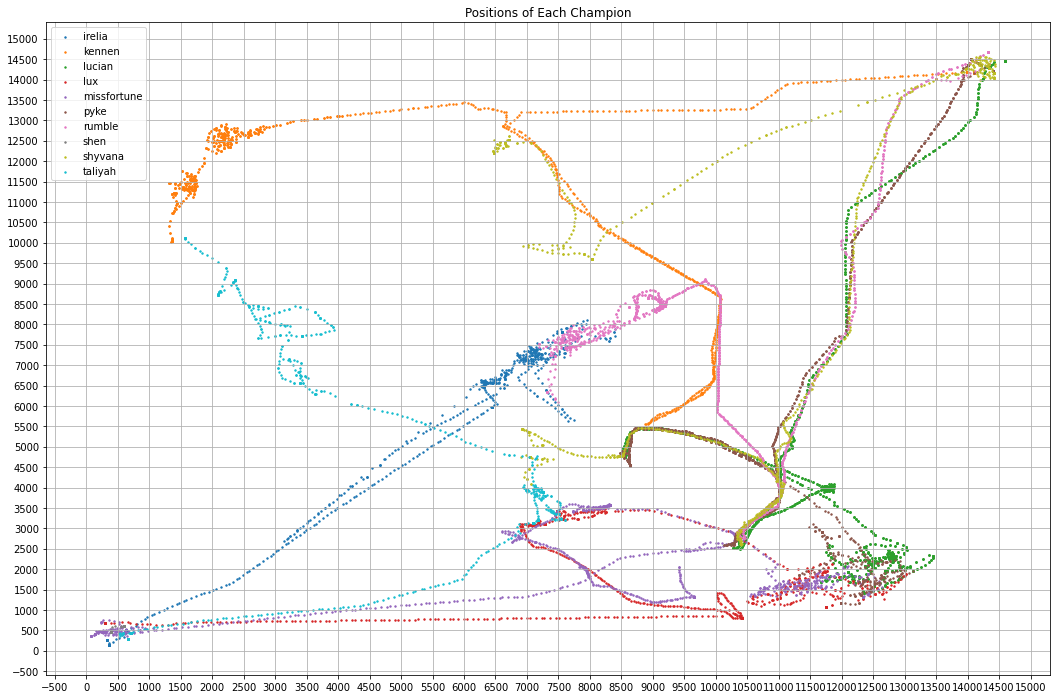

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

plt.rcParams["figure.figsize"] = (6*3, 6*2)

# This splits the map into distinct regions and also makes plotting look nicer
global_region_mult = 2
map_dim  = 16_000
map_width = map_height = map_dim
map_n = int(map_dim / 1000) * global_region_mult
global_intent_region_size = int(map_dim / map_n)

POS_FOR_GAME_QUERY = lambda game_id, champ_name: f"""
SELECT position_x, position_y, position_z
FROM objects
WHERE obj_type='champs' AND game_id={game_id} AND name='{champ_name}'
"""

def plot_pos(x_s, z_s, labels):
  fig, ax = plt.subplots()
  intervals = global_intent_region_size
  
  loc = plticker.MultipleLocator(base=intervals)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)
  ax.grid(which='major', axis='both', linestyle='-')

  plt.title("Positions of Each Champion")

  for x, z, l in zip(x_s, z_s, labels):
    s = ax.scatter(x, z, s=2)
    s.set_label(l)

  ax.legend()

x_s = []
z_s = []

for c in champs_for_game:
  cur.execute(POS_FOR_GAME_QUERY(first_game_id, c))
  pos = cur.fetchall()
  pos_x = [p[0] for p in pos]
  pos_z = [p[2] for p in pos]
  x_s.append(pos_x)
  z_s.append(pos_z)

plot_pos(x_s, z_s, labels=champs_for_game)